# Callbacks From Transformers To Driver

Transformers are the only Fugue extensions to execute on remote worker nodes. For some scenarios, the transformers need to communicate with the driver while it is running. For example, a transformer is training a Keras model, and at the end of each epoch, it needs to report the metrics to the driver and the driver can respond with a decision whether to stop the training.

In Fugue, the callback model is also abstract, you only need to define the callback functions and specify the server to handle remote calls.

## The simplest example

The simplest way to have a call back, is to define a callback parameter in the interfaceless way. You only need to annotate the parameter with `callable`, `Callable` or `Callable` with arguments, for example `Callable[[str],str]`. And this parameter must be after all dataframe parameters and before all other parameters.

In [ ]:
import pandas as pd
from fugue import FugueWorkflow

# schema: *
def print_describe_and_return(df:pd.DataFrame, cb:callable) -> pd.DataFrame:
    cb(str(df.describe()))
    return df

dag = FugueWorkflow()
df = dag.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(print_describe_and_return, callback = lambda x:print(x)).show()

dag.run()

In the above example, it's a typical interfaceless transformer example with two additions: `cb:callback` in the transformer, and `callback = lambda x:print(x)` in the transform function. `cb:callback` is to tell Fugue that we want to use a callback inside the transformation. `callback = lambda x:print(x)` is to define the function that will execute on the driver.

As you can see, since there are 3 partitions of `a`, there are 3 descriptions printed, and in the end, the output dataframe is also printed.

You can make the callback optional

In [ ]:
from typing import Optional, Callable, Any

# schema: *
def print_describe_and_return(df:pd.DataFrame, cb:Optional[Callable[[Any],None]]) -> pd.DataFrame:
    if cb is not None:
        cb(str(df.describe()))
    return df

dag = FugueWorkflow()
df = dag.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(print_describe_and_return, callback = lambda x:print(x)).show()

dag.run()

dag2 = FugueWorkflow()
df = dag2.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(print_describe_and_return).show()

dag2.run()

In the above example we use `Optional` to tell Fugue that this transformer can work with or without the callback. The transformer code is responsible to check null on the callback parameter. And if you don't provide a callback handler when you invoke the transformer, the transformer side will get None on the callback parameter.

This is a more flexible way where your transformer can be used in different situations.


## Callbacks on distributed execution engines

The above code is running using `NativeExecutionEngine` running on the current process. It's the minimal code to test whether your callback logic will work. To run it using a distributed engine, You need to setup the callback server to handle network calls.

In [ ]:
from fugue_spark import SparkExecutionEngine

conf = {
    "fugue.rpc.server": "fugue.rpc.flask.FlaskRPCServer",
    "fugue.rpc.flask_server.host": "0.0.0.0",
    "fugue.rpc.flask_server.port": "1234",
    "fugue.rpc.flask_server.timeout": "2 sec",
}

dag.run(SparkExecutionEngine(conf=conf))

The above code uses the built-in flask server to handle network calls from workers. To use `fugue.rpc.flask.FlaskRPCServer`, you must set `fugue.rpc.flask_server.host` and `fugue.rpc.flask_server.port`, and it's suggested to also set `fugue.rpc.flask_server.timeout` to a reasonable timeout for your own case.

You can also create your custom server by implementing [RPCServer](https://fugue.readthedocs.io/en/latest/api/fugue.rpc.html#fugue.rpc.base.RPCServer) and [RPCClient](https://fugue.readthedocs.io/en/latest/api/fugue.rpc.html#fugue.rpc.base.RPCClient). For example you may create a pair of server and client to communicate with [MLFlow](https://mlflow.org/) to update metrics in real time.


## Stateful callbacks

Commonly, callbacks need to be stateful. In Fugue, it's totally fine to set the callback to be a method of an instance (in order to be stateful), or to use a global method/variable. You only need to make the function thread safe because it could be invoked in parallel.

In [ ]:
from threading import RLock

class Callback(object):
    def __init__(self):
        self.n=0
        self._update_lock = RLock()
        
    def should_skip(self):
        with self._update_lock:
            self.n+=1
            return self.n>=3
                
callback = Callback()
                
                
# schema: *
def take(df:pd.DataFrame, skip:callable) -> pd.DataFrame:
    if not skip():
        return df

dag = FugueWorkflow()
df = dag.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(take, callback = callback.should_skip).show()

dag.run()


In the above example, we only take two partitions of the entire dataframe, so the `Callback` implemented a thread safe counter, and return true or false based on the counter.

**The only requirement** for a callback function that Fugue can use is that its input parameters and output are picklable (Nones are fine). The function itself is OK if not picklable. In the above case, `should_skip` invoked `RLock` which is not picklable, but it doesn't matter.


## Implementing `RPCHandler` instead

In most case the above native approaches are sufficient. However, if you want to having more control on the callback side, you can directly implement [RPCHandler](https://fugue.readthedocs.io/en/latest/api/fugue.rpc.html#fugue.rpc.base.RPCHandler). For example, you want to start a thread to process the incoming calls and stop the thread when the execution finishes.

In [ ]:
from threading import RLock
from fugue.rpc import RPCHandler
from uuid import uuid4

class Callback(RPCHandler):
    def __init__(self):
        super().__init__()  # <-- must call
        self.n=0
        self._update_lock = RLock()
        
    def __uuid__(self) -> str:
        """UUID that can affect the determinism of the workflow"""
        return str(uuid4())  # in this case, it will make the workflow non deterministic

    def start_handler(self) -> None:
        """User implementation of starting the handler"""
        print("counter started")


    def stop_handler(self) -> None:
        """User implementation of stopping the handler"""
        print("counter stopped")
        
    def __call__(self):
        with self._update_lock:
            self.n+=1
            return self.n>=3
                
callback = Callback()
                
                
# schema: *
def take(df:pd.DataFrame, skip:callable) -> pd.DataFrame:
    if not skip():
        return df

dag = FugueWorkflow()
df = dag.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(take, callback = callback).show()

print(dag.spec_uuid())  # every time, the id will be different because the Callback is not deterministic
dag.run()



## Using callbacks in Transformer class

If you must implement a `Transformer`, `OutputTransformer`, `CoTransformer` and `OutputCoTransformer`, then you can use `callback` property as the callback.

In [ ]:
from fugue import FugueWorkflow, Transformer

class PrintAndReturn(Transformer):
    def get_output_schema(self, df):
        return df.schema
    
    def transform(self, df):
        self.callback(str(df.as_pandas().describe()))
        return df

dag = FugueWorkflow()
df = dag.df([[0,0],[1,1],[0,1],[2,2]],"a:int,b:int")
df.partition(by=["a"]).transform(PrintAndReturn, callback = lambda x:print(x)).show()

dag.run()

## A real example: ploting mins in real time

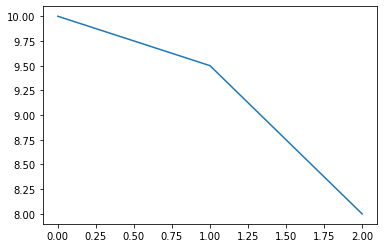

In [16]:
from fugue import FugueWorkflow
from fugue.rpc import RPCHandler
import pandas as pd
import random
from IPython.display import clear_output
from threading import RLock, Thread
from time import sleep
import matplotlib.pyplot as plt

class PlotMinNow(RPCHandler):
    def __init__(self):
        super().__init__()
        self._update_lock = RLock()
        self._values = []
        self._updated = False
        self._shutdown = False
        self._thread = None
        
    def __call__(self, value):
        with self._update_lock:
            if len(self._values)==0 or value<self._values[-1]:
                self._values.append(value)
                self._updated=True

    def start_handler(self):
        def thread():
            def _plot():
                with self._update_lock:
                    data = list(self._values) if self._updated else []
                if len(data)>0:
                    clear_output()
                    pd.Series(data).plot()
                    plt.show()
                    self._updated=False

            while not self._shutdown:
                _plot()
                sleep(1)
            _plot()
        
        self._thread = Thread(target=thread)
        self._thread.start()
        
        
    def stop_handler(self):
        self._shutdown=True
        self._thread.join()
        
with PlotMinNow().start() as p:
    p(10)
    p(9.5)
    p(8)

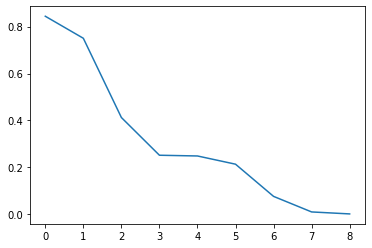

In [17]:
def create() -> pd.DataFrame:
    return pd.DataFrame([[100-x] for x in range(100)], columns=["a"])

def plot(df:pd.DataFrame, p:callable) -> None:
    random.seed(0)
    for v in df["a"]/100.0:
        p(random.random()*v)
        sleep(0.2)

with FugueWorkflow() as dag:
    dag.create(create).out_transform(plot, callback=PlotMinNow())

## Use with caution

Callbacks may be convenient to use, but you should use with caution. For example, it may not be a good idea to direct worker sider logs to driver using this approach because the amount of data can be unexpectedly large.

Also, when you implement the driver side logic for the callbacks, you should be careful about the contention and latency. Take a look at the `_plot` in `PlotMinNow`, it's a consumer competing with the data producers (remote callers), so it minimizes the logic inside the locked part to reduce such contention.

The CPU usage is also a concern, when multiple workers are calling back, it could overload the system. So you should consider decoupling producers and consumers and moving the expensive operations to the consumer side so that you have better control of the load. See `__call__` in `PlotMinNow`, it has very cheap operations, if we re-draw the chart in side `__call__`, it may be a bad idea.


## Callback settings and RPCServer combination (for interfaceless)

For interfaceless settings, you have 3 options on the transformer function: without callable, with callable, with optional callable. And you have the option whether to add the callback handler when you invoke the transformer. And you have the option to set the RPCServer.

The following table is a full list of possible combinations and indicated scenarios

| Callback in transformers | Provide callback handler when using transformers | Customize RPCServer | Scenario
| :---: | :---: | :---: | :---
| No callback | No | No | **Most common**, the callback feature is not used at all
| No callback | No | Yes | *Meaningless*, plus you may introduce overhead to start and stop the server
| No callback | Yes | No | *Meaningless*, plus you may introduce overhead to start and stop the callback handler
| No callback | Yes | Yes | *Meaningless*, plus you may introduce overhead to start and stop the callback handler and the server
| Required | No | No | *Invalid*, Fugue compile time exception will be thrown
| Required | No | Yes | *Invalid*, Fugue compile time exception will be thrown
| Required | Yes | No | **Local only**, you can use it to test your callbacks using `NativeExecutionEngine` only. If you use a distributed engine, serialization exception will be thrown
| Required | Yes | Yes | **Common**, a typical way to use callbacks both locally and distributedly
| Optional | No | No | **Flexible**, the callback on the transformer side will be None, you need to check. For a transformer to run with and without a callback, this is a solution
| Optional | No | Yes | *Meaningless*, plus you may introduce overhead to start and stop the server
| Optional | Yes | No | **Local only**, you can use it to test your callbacks using `NativeExecutionEngine` only. If you use a distributed engine, serialization exception will be thrown
| Optional | Yes | Yes | **Common**, a typical way to use callbacks both locally and distributedly